<a href="https://colab.research.google.com/github/NUDTPingLuo/NTK/blob/main/NTK_features_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install cleverhans neural_tangents

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.3/92.3 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.7/248.7 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.3/97.3 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 13.7 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
tf.config.experimental.set_visible_devices([], "GPU")
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import jax.random as random
import jax
import tensorflow_datasets as tfds
from jax import scipy as sp
from jax import vmap, grad, jacfwd
from jax.example_libraries.stax import logsoftmax
from cleverhans.jax.utils import clip_eta, one_hot
import functools
import neural_tangents as nt
from neural_tangents import stax

In [3]:
def compute_approximate_vectors(vectors_m, k):
    """
    对 m 个向量组成的矩阵进行奇异值分解，选择前 k 个奇异值和对应的奇异向量，重建近似的 m x d 矩阵。

    参数:
        vectors_m (np.ndarray): m 个向量组成的矩阵，形状为 (m, d)。
        k (int): 选择的前 k 个奇异值和奇异向量。

    返回:
        vectors_m_k (np.ndarray): 近似的 m x d 矩阵。
        singular_values (np.ndarray): 前 k 个奇异值，形状为 (k,)。
        singular_vectors (np.ndarray): 对应的右奇异向量，形状为 (d, k)。
    """
    # 1. 对 vectors_m 进行奇异值分解
    U, S, Vt = np.linalg.svd(vectors_m, full_matrices=False)

    # 2. 选择前 k 个奇异值和对应的奇异向量
    U_k = U[:, :k]  # 左奇异向量，形状为 (m, k)
    S_k = S[:k]  # 奇异值，形状为 (k,)
    Vt_k = Vt[:k, :]  # 右奇异向量，形状为 (k, d)

    # 3. 重建近似的 m x d 矩阵
    vectors_m_k = np.dot(U_k, np.dot(np.diag(S_k), Vt_k))

    return vectors_m_k, S_k, Vt_k.T  # Vt_k.T 是右奇异向量的转置，形状为 (d, k)


def compute_full_matrix(vectors_n, vectors_m_k):
    """
    将 n 个向量和近似的 m 个向量组合成 (m+n) x d 矩阵，并计算 (m+n) x (m+n) 的内积矩阵。

    参数:
        vectors_n (np.ndarray): n 个向量组成的矩阵，形状为 (n, d)。
        vectors_m_k (np.ndarray): 近似的 m 个向量组成的矩阵，形状为 (m, d)。

    返回:
        full_matrix (np.ndarray): (m+n) x (m+n) 的内积矩阵。
    """
    # 1. 组合成 (m+n) x d 矩阵
    combined_vectors = np.vstack((vectors_n, vectors_m_k))  # 形状为 (m+n, d)

    # 2. 计算 (m+n) x (m+n) 的内积矩阵
    full_matrix = np.dot(combined_vectors, combined_vectors.T)

    return full_matrix

def compute_eigenvalues(matrix):
    """
    计算矩阵的特征值。
    """
    return np.linalg.eigvals(matrix)

# 示例用法
if __name__ == "__main__":
    # 随机生成数据
    n = 5  # n 个向量
    m = 4  # m 个向量
    d = 3  # 向量维度
    vectors_n = np.random.rand(n, d)  # 随机生成 n 个 d 维向量
    vectors_m = np.random.rand(m, d)  # 随机生成 m 个 d 维向量

    # 选择前 k 个奇异值
    k = 2

    # 对 m 个向量进行奇异值分解，并重建近似的 m x d 矩阵
    vectors_m_k, singular_values, singular_vectors = compute_approximate_vectors(vectors_m, k)

    # 计算 (m+n) x (m+n) 的内积矩阵
    full_matrix_ori = compute_full_matrix(vectors_n, vectors_m)
    full_matrix = compute_full_matrix(vectors_n, vectors_m_k)

    # 计算特征值
    eigenvalues_ori = compute_eigenvalues(full_matrix_ori)  # 原来的矩阵特征值
    eigenvalues = compute_eigenvalues(full_matrix)    # 近似后的矩阵特征值

    # 打印结果
    print("m 个向量的原始矩阵:")
    print(vectors_m)

    print("\n重建的近似的 m x d 矩阵:")
    print(vectors_m_k)

    print("\n(m+n) x (m+n) 的原始内积矩阵:")
    print(full_matrix_ori)

    print("\n(m+n) x (m+n) 的内积矩阵:")
    print(full_matrix)

    print("\n原来的 (m+n)*(m+n) 矩阵的特征值：")
    print(eigenvalues_ori)

    print("\n近似后的 (m+n)*(m+n) 矩阵的特征值：")
    print(eigenvalues)

m 个向量的原始矩阵:
[[0.07581165 0.42455798 0.06233643]
 [0.52791186 0.45810421 0.06173612]
 [0.25219587 0.9098796  0.99510037]
 [0.46652674 0.96674621 0.74753751]]

重建的近似的 m x d 矩阵:
[[0.19804185 0.29827411 0.15130136]
 [0.48958219 0.49770506 0.03383797]
 [0.23817226 0.92436829 0.98489332]
 [0.46197861 0.97144516 0.74422718]]

(m+n) x (m+n) 的原始内积矩阵:
[[1.09199666 1.03050043 0.69177204 1.29298143 0.72810285 0.34515298
  0.53907582 1.40719405 1.34347632]
 [1.03050043 1.23058161 0.91541572 1.53986545 0.73695551 0.33247234
  0.72306161 1.20350183 1.29208194]
 [0.69177204 0.91541572 0.74444576 1.11862418 0.46533149 0.16942222
  0.51616765 0.74679482 0.82904583]
 [1.29298143 1.53986545 1.11862418 1.94388505 0.95459195 0.4540126
  0.93237579 1.52394241 1.65158329]
 [0.72810285 0.73695551 0.46533149 0.95459195 0.55080916 0.29845261
  0.45267937 0.93577947 0.95627377]
 [0.34515298 0.33247234 0.16942222 0.4540126  0.29845261 0.18988271
  0.23836207 0.46744703 0.4924068 ]
 [0.53907582 0.72306161 0.5161676

### Options

In [4]:
DATASET = 'cifar10' #@param ['cifar10', 'mnist']
TASK = 'binary' #@param ['binary', 'multiclass']
TRAIN_BATCH_SIZE = 2000 #@param
TEST_BATCH_SIZE = 100 #@param
RANDOM_LABELS = False
NORMLZ = False #@param {type:"boolean"}

### Utils

In [5]:
def normalize_img(tensor):
    tensor = (tensor - tensor.min()) / (tensor.max() - tensor.min())
    return tensor

def binarize_labels(labels):
    labels = np.array(labels)
    bin = lambda x: -1 if x == 0 else 1
    return jnp.array(np.vectorize(bin)(labels))

def select_data(images, _labels, class1, class2):
    idx = np.logical_or(_labels == class1, _labels == class2)
    images = images[idx]
    labels = _labels[idx]
    return images, labels

def get_tfds_dataset(name):
    assert name in ['cifar10', 'mnist']
    ds_train, ds_test = tfds.as_numpy(
      tfds.load(
          name,
          split=['train', 'test'],
          batch_size=-1,
          as_dataset_kwargs={'shuffle_files': True}))

    return ds_train['image'], ds_train['label'], ds_test['image'], ds_test['label']

def one_hot(x,
            num_classes,
            center=False,
            dtype=np.float32):
    assert len(x.shape) == 1
    one_hot_vectors = np.array(x[:, None] == np.arange(num_classes), dtype)
    if center:
        one_hot_vectors = one_hot_vectors - 1. / num_classes
    return one_hot_vectors

def _fast_gradient_method(
    model_fn, x, eps, norm, clip_min=None, clip_max=None, y=None, binary=True
):

    if y is None:
        # Using model predictions as ground truth to avoid label leaking
        if (binary):
            y = jnp.sign(model_fn(x))
        else:
            x_labels = jnp.argmax(model_fn(x), axis=1)
            y = one_hot(x_labels, 10)


    def loss_adv_multi(image, label):
        pred = model_fn(jnp.expand_dims(image, axis=0))
        loss = -jnp.sum(logsoftmax(pred) * label)
        return loss

    def bce_w_logits(img, y, weight=None, average=False):
        """
        Binary Cross Entropy Loss
        Should be numerically stable, built based on: https://github.com/pytorch/pytorch/issues/751
        :param x: Input tensor
        :param y: Target tensor
        :param weight: Vector of example weights
        :param average: Boolean to average resulting loss vector
        :return: Scalar value
        """
        x = model_fn(img)
        if (-1. in y):
            y = (y+1)/2
        max_val = jnp.clip(x, 0, None)
        loss = x - x * y + max_val + jnp.log(jnp.exp(-max_val) + jnp.exp((-x - max_val)))

        if weight is not None:
            loss = loss * weight

        if average:
            return loss.mean()
        else:
            return loss.sum()

    avoid_zero = 1e-3
    if (binary):
        grads_fn = grad(bce_w_logits)
    else:
        grads_fn = vmap(grad(loss_adv_multi), in_axes=(0, 0), out_axes=0)
    # works for find_rob_kernel
    grads = grads_fn(x, y)

    axis = list(range(1, len(grads.shape)))
    avoid_zero_div = 1e-12
    if norm == np.inf:
        perturbation = eps * jnp.sign(grads)
    elif norm == 2:
        square = np.maximum(
            avoid_zero_div, np.sum(np.square(grads), axis=axis, keepdims=True)
        )
        perturbation = grads / np.sqrt(square)

    adv_x = x + perturbation
    # If clipping is needed, reset all values outside of [clip_min, clip_max]
    if (clip_min is not None) or (clip_max is not None):
        # We don't currently support one-sided clipping
        assert clip_min is not None and clip_max is not None
        adv_x = np.clip(adv_x, a_min=clip_min, a_max=clip_max)
    return adv_x, grads

def _projected_gradient_descent(
    model_fn,
    x,
    eps,
    eps_iter,
    nb_iter,
    norm,
    clip_min=None,
    clip_max=None,
    y=None,
    binary=True,
    rand_init=None,
    rand_minmax=0.3,
):
    """
    This class implements either the Basic Iterative Method
    (Kurakin et al. 2016) when rand_init is set to 0. or the
    Madry et al. (2017) method when rand_minmax is larger than 0.
    Paper link (Kurakin et al. 2016): https://arxiv.org/pdf/1607.02533.pdf
    Paper link (Madry et al. 2017): https://arxiv.org/pdf/1706.06083.pdf
    :param model_fn: a callable that takes an input tensor and returns the model logits.
    :param x: input tensor.
    :param eps: epsilon (input variation parameter); see https://arxiv.org/abs/1412.6572.
    :param eps_iter: step size for each attack iteration
    :param nb_iter: Number of attack iterations.
    :param norm: Order of the norm (mimics NumPy). Possible values: np.inf or 2.
    :param clip_min: (optional) float. Minimum float value for adversarial example components.
    :param clip_max: (optional) float. Maximum float value for adversarial example components.
    :param y: (optional) Tensor with true labels. If targeted is true, then provide the
              target label. Otherwise, only provide this parameter if you'd like to use true
              labels when crafting adversarial samples. Otherwise, model predictions are used
              as labels to avoid the "label leaking" effect (explained in this paper:
              https://arxiv.org/abs/1611.01236). Default is None.
    :param targeted: (optional) bool. Is the attack targeted or untargeted?
              Untargeted, the default, will try to make the label incorrect.
              Targeted will instead try to move in the direction of being more like y.
    :return: a tensor for the adversarial example
    """

    assert eps_iter <= eps, (eps_iter, eps)
    if norm == 1:
        raise NotImplementedError(
            "It's not clear that FGM is a good inner loop"
            " step for PGD when norm=1, because norm=1 FGM "
            " changes only one pixel at a time. We need "
            " to rigorously test a strong norm=1 PGD "
            "before enabling this feature."
        )
    if norm not in [np.inf, 2]:
        raise ValueError("Norm order must be either np.inf or 2.")

    # Initialize loop variables
    if rand_init:
        rand_minmax = eps
        eta = np.random.uniform(x.shape, -rand_minmax, rand_minmax)
    else:
        eta = np.zeros_like(x)

    # Clip eta
    eta = clip_eta(eta, norm, eps)
    adv_x = x + eta
    if clip_min is not None or clip_max is not None:
        adv_x = np.clip(adv_x, a_min=clip_min, a_max=clip_max)

    if y is None:
        # Using model predictions as ground truth to avoid label leaking
        x_labels = np.argmax(model_fn(x), 1)
        y = one_hot(x_labels, 10)

    for _ in range(nb_iter):
        adv_x, _ = _fast_gradient_method(
            model_fn,
            adv_x,
            eps_iter,
            norm,
            clip_min=clip_min,
            clip_max=clip_max,
            y=y,
            binary=binary
        )

        # Clipping perturbation eta to norm norm ball
        eta = adv_x - x
        eta = clip_eta(eta, norm, eps)
        adv_x = x + eta

        # Redo the clipping.
        # FGM already did it, but subtracting and re-adding eta can add some
        # small numerical error.
        if clip_min is not None or clip_max is not None:
            adv_x = np.clip(adv_x, a_min=clip_min, a_max=clip_max)

    return adv_x

class OverCompleteKernel():

    def __init__(self, kernel_fn, x_train, y_train):
        _kernel_fn = nt.batch(kernel_fn, device_count=-1, batch_size=50)
        self.KERNEL_FN = lambda x, x_: kernel_fn(x, x_, 'ntk')
        self._KERNEL_FN = lambda x, x_: _kernel_fn(x, x_, 'ntk')
        self.k_ss = self.KERNEL_FN(x_train, x_train)
        self.x_train, self.y_train = x_train, y_train
        self.inv_k_ss = None
        self.l = None
        self.v = None


    def init_from_matrix(self, kernel_fn, kernel, x_train, y_train):
        self.KERNEL_FN = kernel_fn
        self.k_ss = kernel
        self.x_train, self.y_train = x_train, y_train
        self.inv_k_ss = None
        self.l = None
        self.v = None

    def compute_eig_kernel(self, eig_idx): # temporary fix for OOM bug
        if (self.l == None):
            self.l, self.v = jnp.linalg.eigh(self.inv_k_ss)
        V = jnp.array(jnp.take(self.v, eig_idx, axis=1), ndmin=2)
        Lambda = jnp.array(jnp.diag(jnp.take(self.l, eig_idx).reshape(-1)), ndmin=2)
        try:
            assert eig_idx.shape[0] > 1
            return V @ Lambda @ V.T
        except:
            return V.reshape(-1, 1) @ Lambda.reshape(1, 1) @ V.T.reshape(1, -1)


    def model_fn(self, eig_idx=None):
        if (eig_idx is not None):
            if (self.l is None):
                self.inv_k_ss = jnp.linalg.inv(self.k_ss)
            _inv_idx = self.compute_eig_kernel(eig_idx)
            train_component = _inv_idx @ self.y_train
        else:
            _k_ss = self.k_ss
            print('核矩阵:', _k_ss)
            train_component = sp.linalg.solve(_k_ss, self.y_train, assume_a='pos')

        def model(images):
            return jnp.dot(self.KERNEL_FN(images, self.x_train), train_component)

        return model


def FullyConnectedNetwork(
    depth,
    width,
    W_std = np.sqrt(2),
    b_std = 0.1,
    num_classes = 10,
    parameterization = 'ntk',
    activation = 'relu'):
  """Returns neural_tangents.stax fully connected network."""
  activation_fn = stax.Relu()
  dense = functools.partial(
      stax.Dense, W_std=W_std, b_std=b_std, parameterization=parameterization)

  layers = [stax.Flatten()]
  for _ in range(depth):
    layers += [dense(width), activation_fn]
  layers += [stax.Dense(num_classes, W_std=W_std, b_std=b_std,
                        parameterization=parameterization)]

  return stax.serial(*layers)

def FullyConvolutionalNetwork(
    depth,
    width,
    W_std = np.sqrt(2),
    b_std = 0.1,
    num_classes = 10,
    parameterization = 'ntk',
    activation = 'relu'):
  """Returns neural_tangents.stax fully convolutional network."""
  activation_fn = stax.Relu()
  layers = []
  conv = functools.partial(
      stax.Conv,
      W_std=W_std,
      b_std=b_std,
      padding='SAME',
      parameterization=parameterization)

  for _ in range(depth):
    layers += [conv(width, (3,3)), activation_fn]
  layers += [stax.Flatten(), stax.Dense(num_classes, W_std=W_std, b_std=b_std,
                                        parameterization=parameterization)]

  return stax.serial(*layers)

def MyrtleNetwork(
    depth,
    width,
    W_std = np.sqrt(2),
    b_std = 0.1,
    num_classes = 10,
    parameterization = 'ntk',
    activation = 'relu'):
  """Returns neural_tangents.stax Myrtle network."""
  layer_factor = {5: [1, 1, 1], 7: [1, 2, 2], 10: [2, 3, 3]}
  if depth not in layer_factor.keys():
    raise NotImplementedError(
        'Myrtle network withd depth %d is not implemented!' % depth)
  activation_fn = stax.Relu()
  layers = []
  conv = functools.partial(
      stax.Conv,
      W_std=W_std,
      b_std=b_std,
      padding='SAME',
      parameterization=parameterization)
  layers += [conv(width, (3, 3)), activation_fn]

  # generate blocks of convolutions followed by average pooling for each
  # layer of layer_factor except the last
  for block_depth in layer_factor[depth][:-1]:
    for _ in range(block_depth):
      layers += [conv(width, (3, 3)), activation_fn]
    layers += [stax.AvgPool((2, 2), strides=(2, 2))]

  # generate final blocks of convolution followed by global average pooling
  for _ in range(layer_factor[depth][-1]):
    layers += [conv(width, (3, 3)), activation_fn]
  layers += [stax.GlobalAvgPool()]

  layers += [
      stax.Dense(num_classes, W_std, b_std, parameterization=parameterization)
  ]

  return stax.serial(*layers)

def get_kernel_fn(architecture, depth, width=1000, parameterization='ntk', task='binary'):
  if (task == 'binary'):
      num_classes = 1
  else:
      num_classes = 10
  if architecture == 'FC':
    return FullyConnectedNetwork(depth=depth, width=width, parameterization=parameterization, num_classes=num_classes)
  elif architecture == 'Conv':
    return FullyConvolutionalNetwork(depth=depth, width=width, parameterization=parameterization, num_classes=num_classes)
  elif architecture == 'Myrtle':
    return MyrtleNetwork(depth=depth, width=width, parameterization=parameterization, num_classes=num_classes)
  else:
    raise NotImplementedError(f'Unrecognized architecture {architecture}')

def model_eval(model_eig, i, x_test, y_test, img_index, i_to_label, suppress=False):
    binary = True if TASK == 'binary' else False
    print(f'----||--Eigenvector {i} stats--||----\n')
    print('Accuracy on cars', jnp.sum(jnp.logical_and(jnp.sign(model_eig(x_test)) == y_test, y_test == -jnp.ones_like(y_test))) / jnp.sum(y_test == -jnp.ones_like(y_test)))
    print('Accuracy on airplanes', jnp.sum(jnp.logical_and(jnp.sign(model_eig(x_test)) == y_test, y_test == jnp.ones_like(y_test))) / jnp.sum(y_test == jnp.ones_like(y_test)))
    # Natural accuracy
    if (TASK == 'binary'):
        assert model_eig(x_test).shape == (TEST_BATCH_SIZE,)
        nat_acc = jnp.mean(jnp.sign(model_eig(x_test)) == y_test)
    else:
        assert model_eig(x_test).shape[0] == TEST_BATCH_SIZE and model_eig(x_test).shape[1] == 10
        nat_acc = jnp.mean(model_eig(x_test).argmax(axis=1) == y_test.argmax(axis=1))
    print('Total accuracy', nat_acc)
    # Robust accuracy
    adv_x, grads = _fast_gradient_method(model_eig, x_test, eps=8/255, norm=np.inf, clip_min=0, clip_max=1, y=y_test, binary=binary)
    if (TASK == 'binary'):
        assert model_eig(x_test).shape == (TEST_BATCH_SIZE,)
        rob_acc = jnp.mean(jnp.sign(model_eig(adv_x)) == y_test)
    else:
        assert model_eig(x_test).shape[0] == TEST_BATCH_SIZE and model_eig(x_test).shape[1] == 10
        rob_acc = jnp.mean(model_eig(adv_x).argmax(axis=1) == y_test.argmax(axis=1))
    print(f"Robust accuracy (using test labels) {rob_acc}")

    if (suppress):
        return nat_acc, rob_acc
    plt.imshow((normalize_img(grads[img_index])))
    plt.axis('off')
    plt.show()
    plt.close()
    print('\n')
    return nat_acc, rob_acc, grads

img_index = 1
i_to_label = {0: 'airplane', 1:  'car'}

## Load data

In [6]:
X_TRAIN_RAW, LABELS_TRAIN, X_TEST_RAW, LABELS_TEST = get_tfds_dataset(DATASET)
if (TASK == 'binary'):
    X_TRAIN_RAW, LABELS_TRAIN = select_data(X_TRAIN_RAW, LABELS_TRAIN, 0, 1) # please only use 0 and 1 for classes - otherwise change binarize_labels, too
    X_TEST_RAW, LABELS_TEST = select_data(X_TEST_RAW, LABELS_TEST, 0, 1)
    Y_TRAIN = binarize_labels(LABELS_TRAIN)
    Y_TEST = binarize_labels(LABELS_TEST)
else:
    Y_TRAIN, Y_TEST = one_hot(LABELS_TRAIN, 10, center=False), one_hot(LABELS_TEST, 10, center=False)

X_TRAIN, X_TEST = X_TRAIN_RAW / 255, X_TEST_RAW / 255
print(len(X_TRAIN), len(X_TEST))

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.9SOZCN_3.0.2/cifar10-train.tfrecord*...:   0%|         …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.9SOZCN_3.0.2/cifar10-test.tfrecord*...:   0%|          …

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.
10000 2000


In [7]:
x_train, y_train = X_TRAIN[:TRAIN_BATCH_SIZE], Y_TRAIN[:TRAIN_BATCH_SIZE]
x_test, y_test = X_TEST[:TEST_BATCH_SIZE], Y_TEST[:TEST_BATCH_SIZE]
print(len(x_train), len(x_test))

2000 100


## Kernel inference

In [8]:
def fit(x_train, y_train, x_test, y_test, TASK, depth=2):
    binary = True if TASK == 'binary' else False
    aux = []
    _, _, kernel_fn = get_kernel_fn('FC', depth=depth, task=TASK)
    kernel_obj = OverCompleteKernel(kernel_fn, x_train, y_train)
    model = kernel_obj.model_fn()
    print("Full kernel stats")
    if (TASK == 'binary'):
#         assert model(x_test).shape == (x_test.shape[0],)
        _acc = jnp.mean(jnp.sign(model(x_test)) == y_test)
        aux.append(_acc)
    else:
#         assert model(x_test).shape[0] == x_test.shape[0] and model(x_test).shape[1] == 10
        _acc = jnp.mean(model(x_test).argmax(axis=1) == y_test.argmax(axis=1))
        aux.append(_acc)
    print(f"Natural accuracy {_acc}")
    adv_x, grad = _fast_gradient_method(model, x_test, eps=8/255, norm=np.inf, clip_min=0, clip_max=1, y=y_test)
    adv_x_pgd = _projected_gradient_descent(model, x_test, eps=8/255, eps_iter=0.01, nb_iter=10, norm=np.inf, clip_min=0, clip_max=1, y=y_test)
    if (TASK == 'binary'):
#         assert model(adv_x).shape == (x_test.shape[0],)
        _acc = jnp.mean(jnp.sign(model(adv_x)) == y_test)
        aux.append(_acc)
        print(f'Robust fgsm accuracy (using test labels) {_acc}')
        _acc = jnp.mean(jnp.sign(model(adv_x_pgd)) == y_test)
        aux.append(_acc)
    else:
#         assert model(adv_x).shape[0] == x_test.shape[0] and model(adv_x).shape[1] == 10
        _acc = jnp.mean(model(adv_x).argmax(axis=1) == y_test.argmax(axis=1))
        aux.append(_acc)
        print(f'Robust fgsm accuracy (using test labels) {_acc}')
        _acc = jnp.mean(model(adv_x_pgd).argmax(axis=1) == y_test.argmax(axis=1))
        aux.append(_acc)
    print(f"Robust pgd accuracy (using test labels) {_acc}")
    return kernel_obj, model, aux, adv_x, grad

In [9]:
kernel_obj, model, aux, adv_x, grads = fit(x_train, y_train, x_test, y_test, TASK, depth=1)

核矩阵: [[0.62863386 0.58434635 0.6505234  ... 0.6129168  0.5602131  0.706003  ]
 [0.58434635 0.95803404 0.8610077  ... 0.79727864 0.68989223 0.8761487 ]
 [0.6505234  0.8610077  1.0665395  ... 0.8258834  0.8085429  0.97476244]
 ...
 [0.6129168  0.79727864 0.8258834  ... 0.90819997 0.77821904 0.9471024 ]
 [0.5602131  0.68989223 0.8085429  ... 0.77821904 1.041183   0.91819215]
 [0.706003   0.8761487  0.97476244 ... 0.9471024  0.91819215 1.381172  ]]
Full kernel stats
Natural accuracy 0.8100000023841858
Robust fgsm accuracy (using test labels) 0.019999999552965164
Robust pgd accuracy (using test labels) 0.019999999552965164


### Show different NTK features

----||--Eigenvector 0 stats--||----

Accuracy on cars 1.0
Accuracy on airplanes 0.0
Total accuracy 0.5
Robust accuracy (using test labels) 0.5


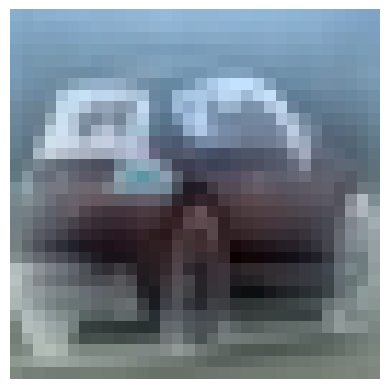



----||--Eigenvector 1 stats--||----

Accuracy on cars 0.74
Accuracy on airplanes 0.62
Total accuracy 0.68
Robust accuracy (using test labels) 0.5


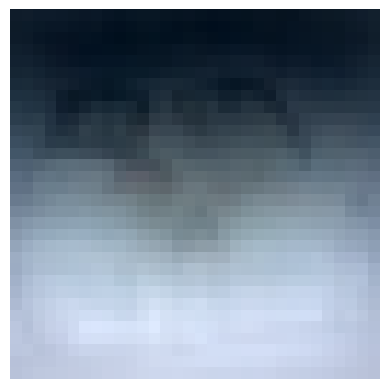



----||--Eigenvector 2 stats--||----

Accuracy on cars 0.5
Accuracy on airplanes 0.58
Total accuracy 0.53999996
Robust accuracy (using test labels) 0.4699999988079071


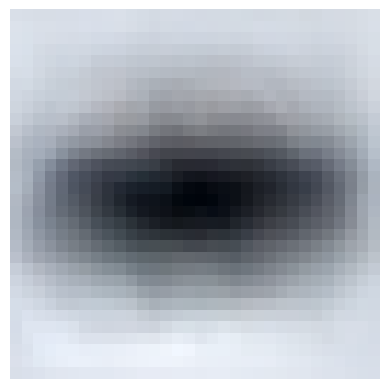



----||--Eigenvector 3 stats--||----

Accuracy on cars 0.59999996
Accuracy on airplanes 0.62
Total accuracy 0.61
Robust accuracy (using test labels) 0.4399999976158142


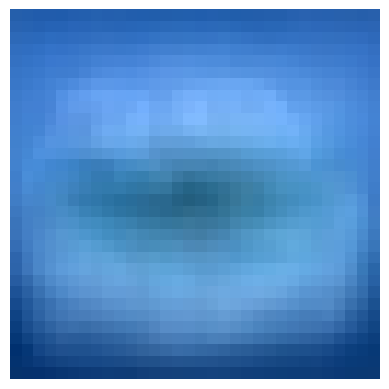



----||--Eigenvector 4 stats--||----

Accuracy on cars 0.45999998
Accuracy on airplanes 0.52
Total accuracy 0.48999998
Robust accuracy (using test labels) 0.32999998331069946


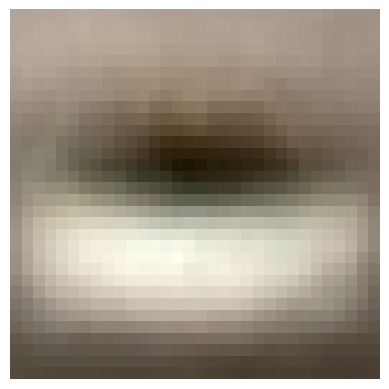



----||--Eigenvector 5 stats--||----

Accuracy on cars 0.58
Accuracy on airplanes 0.53999996
Total accuracy 0.56
Robust accuracy (using test labels) 0.32999998331069946


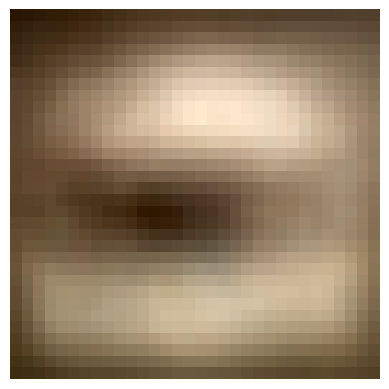



----||--Eigenvector 10 stats--||----

Accuracy on cars 0.52
Accuracy on airplanes 0.65999997
Total accuracy 0.59
Robust accuracy (using test labels) 0.25


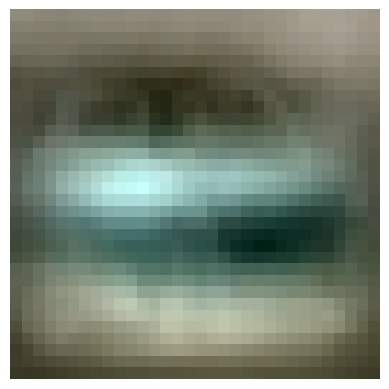



----||--Eigenvector 25 stats--||----

Accuracy on cars 0.45999998
Accuracy on airplanes 0.56
Total accuracy 0.51
Robust accuracy (using test labels) 0.07000000029802322


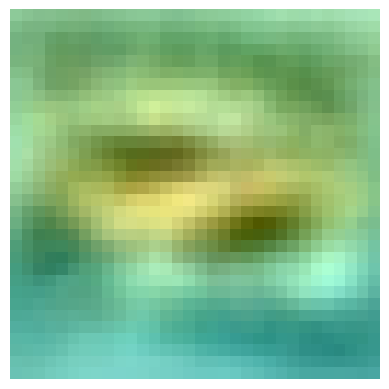



----||--Eigenvector 1500 stats--||----

Accuracy on cars 0.52
Accuracy on airplanes 0.45999998
Total accuracy 0.48999998
Robust accuracy (using test labels) 0.0


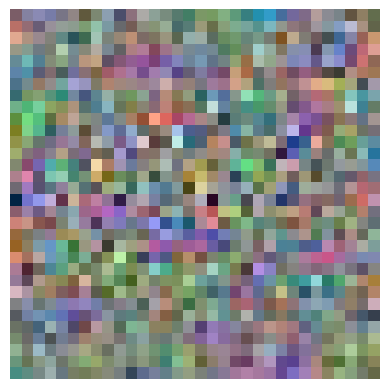



----||--Eigenvector 1987 stats--||----

Accuracy on cars 0.59999996
Accuracy on airplanes 0.52
Total accuracy 0.56
Robust accuracy (using test labels) 0.0


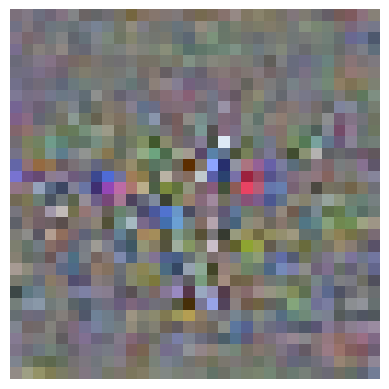



----||--Eigenvector 1988 stats--||----

Accuracy on cars 0.56
Accuracy on airplanes 0.44
Total accuracy 0.5
Robust accuracy (using test labels) 0.0


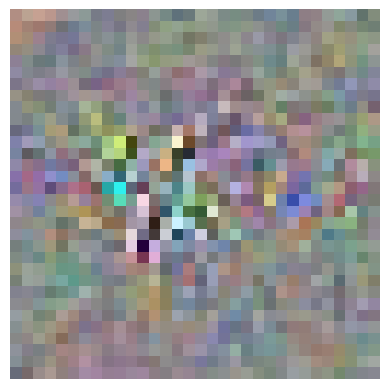



----||--Eigenvector 1998 stats--||----

Accuracy on cars 0.44
Accuracy on airplanes 0.5
Total accuracy 0.47
Robust accuracy (using test labels) 0.0


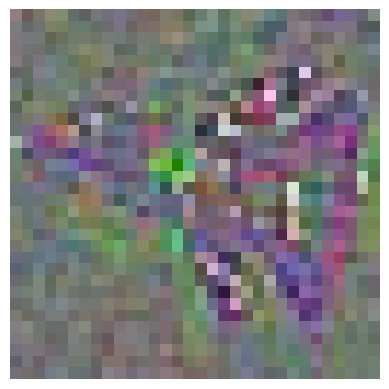

In [10]:
new_grads = {}
ntk_feats_indx = [0, 1, 2, 3, 4, 5, 10, 25, 1500, 1987, 1988, 1998] # change these if you'd like
for j in ntk_feats_indx:
    model_check = kernel_obj.model_fn(jnp.array(j))
    _, _, new_grads[j] = model_eval(model_check, str(j), x_test, y_test, img_index, i_to_label)